# Rental bike forecasting using SARIMAX

In [1]:
library(readr)
library(dplyr)
library(ggplot2)
library(gridExtra)
library(xts)
library(fpp2)
library(DMwR)
library(Metrics)
library(tseries)


Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Attaching package: ‘gridExtra’

The following object is masked from ‘package:dplyr’:

    combine

Loading required package: zoo

Attaching package: ‘zoo’

The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric


Attaching package: ‘xts’

The following objects are masked from ‘package:dplyr’:

    first, last

Loading required package: forecast
Loading required package: fma
Loading required package: expsmooth
Loading required package: lattice
Loading required package: grid

Attaching package: ‘DMwR’

The following object is masked from ‘package:fma’:

    sales


Attaching package: ‘Metrics’

The following object is masked from ‘package:forecast’:

    accuracy



In [2]:
options(repr.plot.width=8, repr.plot.height=4)

## 1. Data import

In [3]:
path <- '../data/bike/bike-sharing-processed.csv'
data <- read_csv(path)

Parsed with column specification:
cols(
  date = col_date(format = ""),
  season = col_double(),
  yr = col_double(),
  mnth = col_double(),
  holiday = col_double(),
  weekday = col_double(),
  workingday = col_double(),
  weathersit = col_double(),
  temp = col_double(),
  atemp = col_double(),
  hum = col_double(),
  windspeed = col_double(),
  cnt = col_double(),
  HurricaneSandy = col_double()
)


In [4]:
head(data)
tail(data)
nrow(data)

date,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt,HurricaneSandy
2011-01-01,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.1604460,985,0
2011-01-02,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.2485390,801,0
2011-01-03,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.2483090,1349,0
2011-01-04,1,0,1,0,2,1,1,0.200000,0.212122,0.590435,0.1602960,1562,0
2011-01-05,1,0,1,0,3,1,1,0.226957,0.229270,0.436957,0.1869000,1600,0
2011-01-06,1,0,1,0,4,1,1,0.204348,0.233209,0.518261,0.0895652,1606,0


date,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt,HurricaneSandy
2012-12-26,1,1,12,0,3,1,3,0.243333,0.220333,0.823333,0.316546,441,1
2012-12-27,1,1,12,0,4,1,2,0.254167,0.226642,0.652917,0.350133,2114,1
2012-12-28,1,1,12,0,5,1,2,0.253333,0.255046,0.590000,0.155471,3095,1
2012-12-29,1,1,12,0,6,0,2,0.253333,0.242400,0.752917,0.124383,1341,1
2012-12-30,1,1,12,0,0,0,1,0.255833,0.231700,0.483333,0.350754,1796,1
2012-12-31,1,1,12,0,1,1,2,0.215833,0.223487,0.577500,0.154846,2729,1


[1] 731

## 2. Convert to ts object

In [5]:
# define date range as per the data
date_range <- seq(as.Date('2011-01-01'), as.Date('2012-12-31'), by='day')

# no need to put the date column as it will generate as ts index
dayofyear <- as.numeric(format(date_range[1], '%j'))

bike_data <- ts(data[, 2:14], start=c(2011, dayofyear), frequency = 365)

In [6]:
head(bike_data)

season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt,HurricaneSandy
1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.1604460,985,0
1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.2485390,801,0
1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.2483090,1349,0
1,0,1,0,2,1,1,0.200000,0.212122,0.590435,0.1602960,1562,0
1,0,1,0,3,1,1,0.226957,0.229270,0.436957,0.1869000,1600,0
1,0,1,0,4,1,1,0.204348,0.233209,0.518261,0.0895652,1606,0


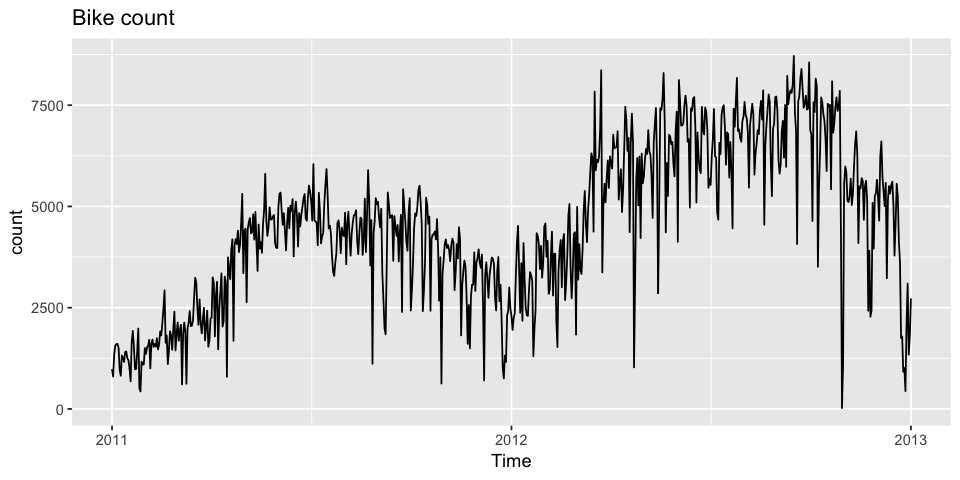

In [7]:
autoplot(bike_data[, 12]) +
    ggtitle('Bike count') +
    ylab('count')

## 3. Data analysis

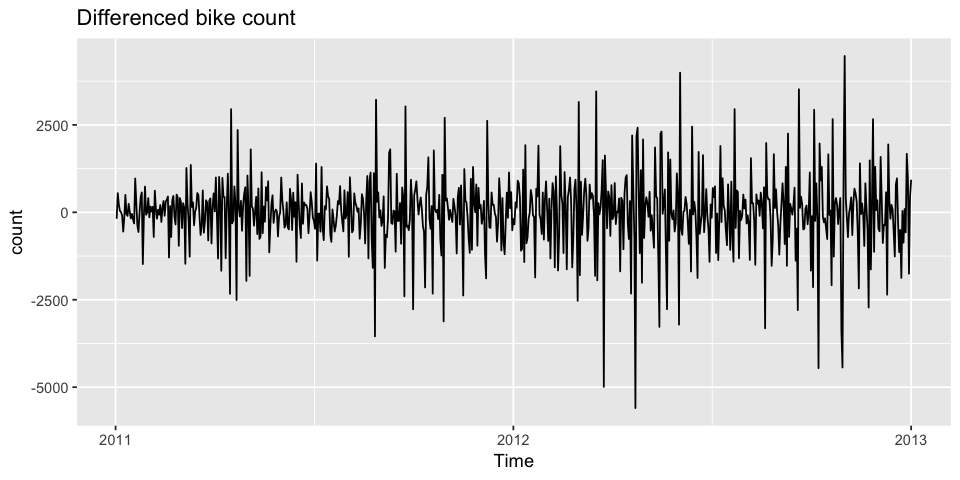

In [8]:
autoplot(diff(bike_data[, 12])) +
    ggtitle('Differenced bike count') +
    ylab('count')

- The data seems to be I(1)

## 3. Train test split

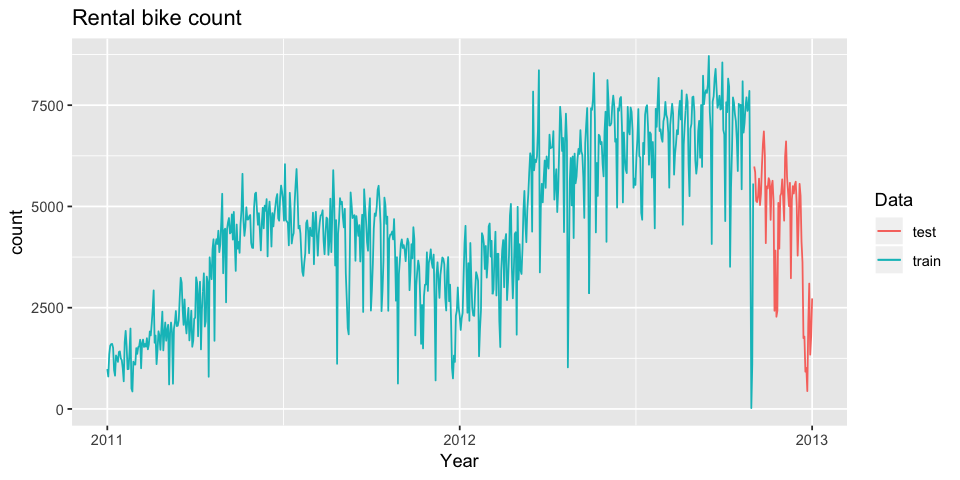

In [9]:
# train and test split
# last 2 month will be test set rest training set
# we will drop the explanatory  variables for baseline models
# as they will not be need for forecasting

test_size <- as.numeric(61)
train_size <- nrow(bike_data)- test_size

train <- head(bike_data, train_size)
test <- tail(bike_data, test_size)

autoplot(train[, 12], series = 'train') + 
    autolayer(test[, 12], series = 'test') +
    ggtitle('Rental bike count') +
    ylab('count') + 
    xlab('Year') +
    guides(colour=guide_legend(title="Data"))

In [10]:
tail(train[, 12])

Time Series:
Start = c(2012, 300) 
End = c(2012, 305) 
Frequency = 365 
[1] 7444 7852 4459   22 1096 5566

In [11]:
head(test[, 12])

Time Series:
Start = c(2012, 306) 
End = c(2012, 311) 
Frequency = 365 
[1] 5986 5847 5138 5107 5259 5686

In [12]:
head(train)

season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt,HurricaneSandy
1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.1604460,985,0
1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.2485390,801,0
1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.2483090,1349,0
1,0,1,0,2,1,1,0.200000,0.212122,0.590435,0.1602960,1562,0
1,0,1,0,3,1,1,0.226957,0.229270,0.436957,0.1869000,1600,0
1,0,1,0,4,1,1,0.204348,0.233209,0.518261,0.0895652,1606,0


In [13]:
# extract exogenous variables
exog_col <- colnames(train)[8:11]

# hurricane sandy to the exogenous list
# exog_col <- c(exog_col, colnames(train)[13])

train_exog <- train[, exog_col]
test_exog <- test[, exog_col]

head(train_exog)
# head(test_exog)

temp,atemp,hum,windspeed
0.344167,0.363625,0.805833,0.1604460
0.363478,0.353739,0.696087,0.2485390
0.196364,0.189405,0.437273,0.2483090
0.200000,0.212122,0.590435,0.1602960
0.226957,0.229270,0.436957,0.1869000
0.204348,0.233209,0.518261,0.0895652


## 4. Order evaluation using auto.arima()

In [14]:
model <- auto.arima(train[, 12], d = 1, D = 1, max.p = 2, max.q = 2, max.P = 2,
          max.Q = 2, max.d = 1, max.D = 1, start.p = 0,
          start.q = 0, start.P = 0, start.Q = 0)

In [15]:
summary(model)

Series: train[, 12] 
ARIMA(1,1,1)(0,1,0)[365] 

Coefficients:
         ar1      ma1
      0.2636  -0.9276
s.e.  0.0649   0.0286

sigma^2 estimated as 1666471:  log likelihood=-2612.12
AIC=5230.24   AICc=5230.32   BIC=5241.39

Training set error measures:
                   ME     RMSE      MAE       MPE     MAPE      MASE
Training set 11.17378 866.6923 415.1966 -47.38094 54.25316 0.1688453
                    ACF1
Training set 0.005671186


## 5. Model fitting

In [16]:
# use arima order determined in previous step
# fit <- Arima(train[, 12], order = c(1, 1, 1), seasonal = c(0, 1, 0),
#             include.mean=FALSE, xreg=train_exog)
# saveRDS(fit, '../checkpoints/bike-sharing/R-models/sarimax-v1.rds')

In [17]:
fit <- readRDS('../checkpoints/bike-sharing/R-models/sarimax-v1.rds')

In [18]:
train_pred <- fitted(fit)                            
test_pred <- forecast(fit, h=61, xreg=test_exog)$mean

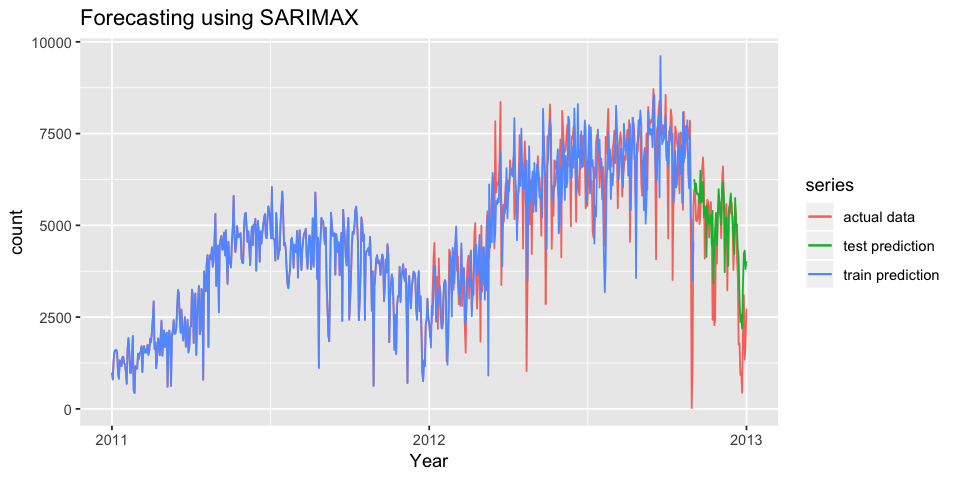

In [19]:
autoplot(bike_data[, 12], series = 'actual data') +
    autolayer(train_pred, series = 'train prediction') +
    autolayer(test_pred, series = 'test prediction') +
    xlab('Year') +
    ylab('count') +
    ggtitle('Forecasting using SARIMAX')

## 6. Model evaluation

In [20]:
train_rmse <- sqrt(mse(train[, 12], train_pred))
train_mae <- mae(train[, 12], train_pred)
train_nrmse <- train_rmse/sd(train[, 12])

test_rmse <- sqrt(mse(test[, 12], test_pred))
test_mae <- mae(test[, 12], test_pred)
test_nrmse <- test_rmse/sd(test[, 12])

print(paste0('Training NRMSE :', round(train_nrmse, 3)))
print(paste0('Training MAE :', round(train_mae, 3)))

print(paste0('Test NRMSE :', round(test_nrmse, 3)))
print(paste0('Test MAE :', round(test_mae, 3)))

[1] "Training NRMSE :0.377"
[1] "Training MAE :354.585"
[1] "Test NRMSE :0.68"
[1] "Test MAE :808.585"


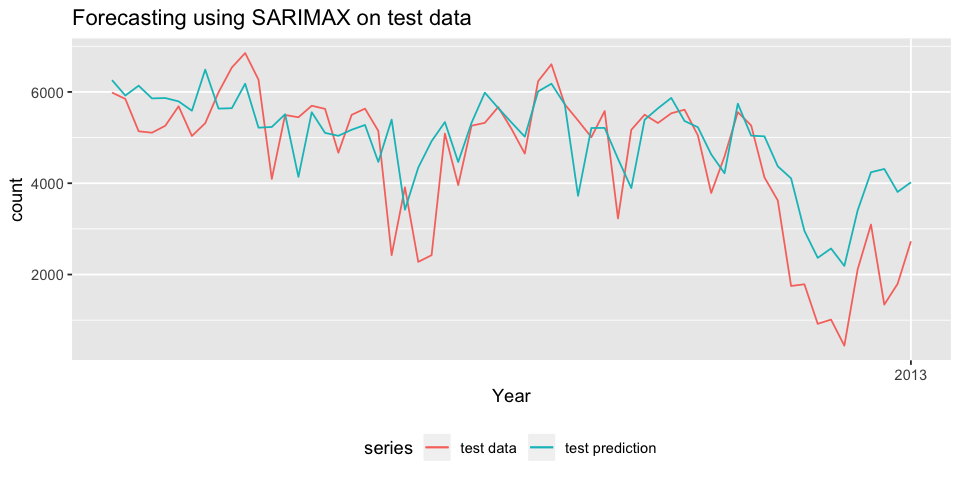

In [21]:
autoplot(test[, 12], series = 'test data') +
    autolayer(test_pred, series = 'test prediction') +
    xlab('Year') +
    ylab('count') +
    ggtitle('Forecasting using SARIMAX on test data') +
    theme(legend.position="bottom", legend.box = "horizontal")

## 7. Residual and co-efficient analysis

Series: train[, 12] 
Regression with ARIMA(1,1,1)(0,1,0)[365] errors 

Coefficients:
         ar1      ma1      temp      atemp         hum   windspeed
      0.3181  -0.9214  3722.671   841.1244  -3298.9396  -2589.1698
s.e.  0.0791   0.0436  2035.774  2048.4309    373.3004    634.2482

sigma^2 estimated as 1234455:  log likelihood=-2564.39
AIC=5142.78   AICc=5143.16   BIC=5168.8

Training set error measures:
                   ME     RMSE      MAE       MPE    MAPE      MASE        ACF1
Training set 9.790382 740.9833 354.5853 -36.22509 42.2925 0.1441969 -0.01206287

	Ljung-Box test

data:  Residuals from Regression with ARIMA(1,1,1)(0,1,0)[365] errors
Q* = 325.03, df = 128, p-value < 2.2e-16

Model df: 6.   Total lags used: 134



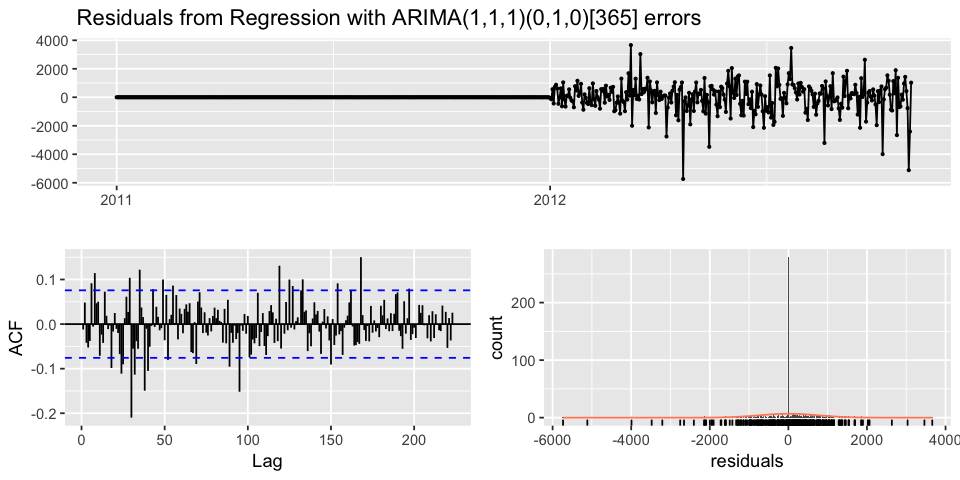

In [22]:
summary(fit)
checkresiduals(fit)